# Comparing mouse behavior to HMM with Thompson Sampling

In [1]:
import sys
sys.path.append('/Users/shayneufeld/GitHub/mouse_bandit/data_preprocessing_code')
sys.path.append('/Users/shayneufeld/GitHub/mouse_bandit')
import support_functions as sf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy as sp
import bandit_preprocessing as bp
%matplotlib inline 

## load in csv files (from running exportTrials.m)

In [3]:
data = pd.read_csv('/Users/shayneufeld/GitHub/mouse_bandit/data/processed_data/new_master_8020_df.csv',index_col=0)

In [4]:
data.head(2)

,Mouse ID,Session ID,Block Trial,Port Streak,Reward Streak,10_Port,10_Reward,10_ITI,10_trialDuration,9_Port,...,2_trialDuration,1_Port,1_Reward,1_ITI,1_trialDuration,0_ITI,Decision,Switch,Higher p port,Reward
0,dumble,70716,11.0,10.0,-1.0,1.0,1.0,1.801,0.439,1.0,...,0.325,1.0,0.0,2.133,0.482,1.411,1.0,0.0,1.0,0.0
1,dumble,70716,12.0,10.0,-2.0,1.0,1.0,1.828,0.353,1.0,...,0.482,1.0,0.0,1.411,0.435,2.169,0.0,1.0,0.0,0.0


# Looking more closely at the switch trials

/Users/shayneufeld/anaconda/envs/cagrin/lib/python3.5/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/shayneufeld/anaconda/envs/cagrin/lib/python3.5/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/shayneufeld/anaconda/envs/cagrin/lib/python3.5/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/shayneufeld/anaconda/envs/cagrin/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/shayneufeld/anaconda/envs/cagrin/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer

total # of blocks in dataset: ~152


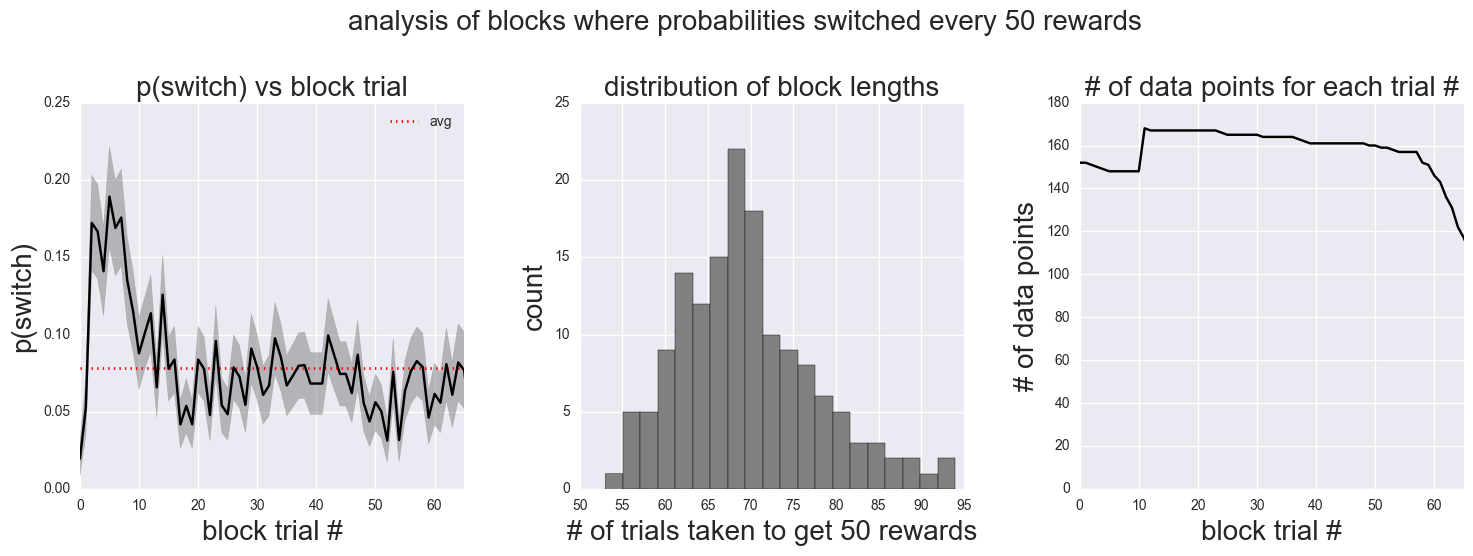

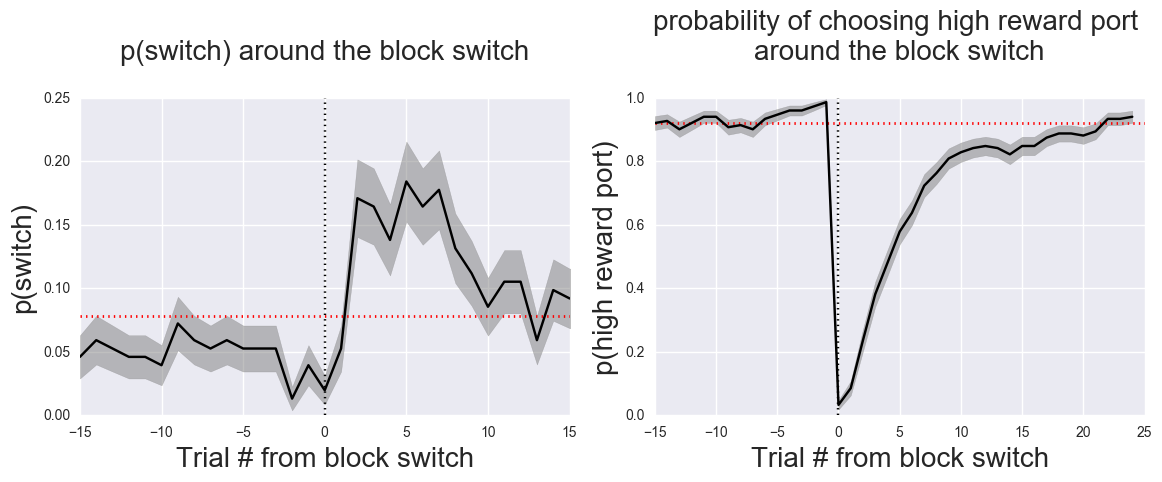

In [5]:
switches = data['Switch'].values

t_block_unique = np.unique(data['Block Trial'].values)
p_switch_block = np.zeros((t_block_unique.shape[0],2))
high_p_port = np.zeros_like(p_switch_block)
trial_block_count = np.zeros_like(t_block_unique)

for t in t_block_unique:
    p_switch_block[t,0] = data[data['Block Trial'] == t]['Switch'].mean(axis=0)
    trial_block_count[t] = data[data['Block Trial'] == t].shape[0]
    p_switch_block[t,1] = data[data['Block Trial'] == t]['Switch'].std(axis=0) / np.sqrt(trial_block_count[t])
    
    high_p_port[t,0] = data[data['Block Trial']==t]['Higher p port'].mean(axis=0)
    high_p_port[t,1] = data[data['Block Trial']==t]['Higher p port'].std(axis=0) / np.sqrt(trial_block_count[t])
    

x_end=65
plt.figure(figsize=(15,5))
plt.suptitle('analysis of blocks where probabilities switched every 50 rewards',x=0.5,y=1.1,fontsize=20)

plt.subplot(131)
plt.plot(t_block_unique,p_switch_block[:,0],color='black')
plt.fill_between(t_block_unique,p_switch_block[:,0]+p_switch_block[:,1],p_switch_block[:,0]-p_switch_block[:,1],color='grey',alpha=0.5)
plt.hlines(data['Switch'].mean(axis=0),xmin=0,xmax=x_end,color='red',linestyle='dotted',label='avg',linewidth=2)
plt.legend(loc='upper right')
plt.xlim(0,x_end)
plt.ylim(0,0.25)
plt.xlabel('block trial #',fontsize=20)
plt.ylabel('p(switch)',fontsize=20)
plt.title('p(switch) vs block trial',fontsize=20)

plt.subplot(132)
plt.hist(data.iloc[np.where(data['Block Trial']==0)[0]-1]['Block Trial'],bins=20,color='grey')
plt.title('distribution of block lengths',fontsize=20)
plt.xlabel('# of trials taken to get 50 rewards',fontsize=20)
plt.ylabel('count',fontsize=20)

plt.subplot(133)
plt.plot(t_block_unique,trial_block_count,color='black')
plt.title('# of data points for each trial #',fontsize=20)
plt.ylabel('# of data points',fontsize=20)
plt.xlabel('block trial #',fontsize=20)
plt.xlim(0,x_end)

plt.tight_layout()
print('total # of blocks in dataset: ~%.0f' % (np.sum(data['Block Trial']==0)))

data.index = np.arange(data.shape[0]) # <-- this is important
switch_points = data[data['Block Trial'] == 0].index.values

L = 15
paraswitch = np.zeros((switch_points.shape[0],L*2 + 10))
paraswitch_port = np.zeros_like(paraswitch)

for i,point in enumerate(switch_points):
    paraswitch[i,:] = data.iloc[point-L:point+L+10]['Switch']
    paraswitch_port[i,:] = data.iloc[point-L:point+L+10]['Higher p port'] 

u = paraswitch.mean(axis=0)
s = paraswitch.std(axis=0)
SE = s/np.sqrt(paraswitch.shape[0])
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.plot(np.arange(-1*L,L+10),u,color='black')
plt.fill_between(np.arange(-1*L,L+10),u+SE,u-SE,color='grey',alpha=0.5)
plt.vlines(x=0,ymin=0,ymax=0.5,color='black',linestyle='dotted')
plt.hlines(data['Switch'].mean(axis=0),xmin=-1*L,xmax=L+1,color='red',linestyle='dotted',label='avg',linewidth=2)
plt.xlabel('Trial # from block switch',fontsize=20)
plt.ylabel('p(switch)',fontsize=20)
plt.title('p(switch) around the block switch',fontsize=20,x=0.5,y=1.1)
plt.xlim(-1*L,L)
plt.ylim(0,0.25)

plt.subplot(122)
u = paraswitch_port.mean(axis=0)
s = paraswitch_port.std(axis=0)
SE = s/np.sqrt(paraswitch.shape[0])
plt.plot(np.arange(-1*L,L+10),u,color='black')
plt.fill_between(np.arange(-1*L,L+10),u+SE,u-SE,color='grey',alpha=0.5)
plt.vlines(x=0,ymin=0,ymax=1,color='black',linestyle='dotted')
plt.hlines(0.92,xmin=-1*L,xmax=L+10,color='red',linestyle='dotted',label='avg',linewidth=2)
plt.xlabel('Trial # from block switch',fontsize=20)
plt.ylabel('p(high reward port)',fontsize=20)
plt.title('probability of choosing high reward port \naround the block switch',fontsize=20,x=0.5,y=1.1)
plt.xlim(-1*L,L+10)
plt.ylim(0,1)

plt.tight_layout()